In [ ]:
!pip install -q keras sklearn tensorflow jupyter 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections

import sklearn
from sklearn import metrics
from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model

from keras.utils import np_utils

import cv2
import os
import zipfile 
from google.colab import drive


In [ ]:
train_Directory = './drive/MyDrive/TFG/TFG_Compartido/ORL/ORL_Combined/ORL_Combined_Train/'
test_Directory = './drive/MyDrive/TFG/TFG_Compartido/ORL/ORL_Combined/ORL_Combined_Test/'




In [ ]:

ntoTest = ntoTrain = classes = 0

for _, dirnames, filenames in os.walk(train_Directory):
    classes += len(dirnames)
    ntoTrain += len(filenames)
    
for _, dirnames, filenames in os.walk(test_Directory):
    ntoTest += len(filenames)
    

print (str(classes) + " classes found.")
print("Train files: " + str(ntoTrain))
print("Test files: " + str(ntoTest))

40 classes found.
Train files: 549
Test files: 309


In [ ]:
batch_size = 7
n_classes = classes
imgL = 224
imgDims = (imgL, imgL)
input_shape = (imgL,imgL,3)

In [ ]:
def extract_y(y_dummy):
  label_vector = []
  i = 0
  while (i < len(y_dummy)):
    j = 0
    while (j < len(y_dummy[i])):
      if (y_dummy[i][j]):
        label_vector.append(j)
        break
      j += 1  
    i += 1
  return label_vector



In [ ]:


dataAugmentTrain = 2
dataAugmentTest = 1

IDG_train = ImageDataGenerator(rotation_range = 10,brightness_range= (0.1, 0.2)) ## rescale=1./255
IDG_test = ImageDataGenerator(rotation_range = 10,brightness_range= (0.1, 0.2) ) ## rescale=1./255
train_generator = IDG_train.flow_from_directory(
    directory = train_Directory, class_mode = 'categorical', batch_size = ntoTrain,
    target_size=imgDims, color_mode='rgb', shuffle = True
)

test_generator = IDG_test.flow_from_directory(
    directory = test_Directory, class_mode = 'categorical', batch_size = ntoTest,
    target_size=imgDims, color_mode='rgb', shuffle = True
)
print(len(train_generator.labels))
# Obtenemos los arrays de imagenes-labels

x_train,dummy_vector = train_generator.next()
y_train =  extract_y(dummy_vector)
x_test,dummy_vector = test_generator.next()
y_test =  extract_y(dummy_vector)

x = dataAugmentTrain
while x > 0:
  x_train2,dummy_vector = train_generator.next()
  y_train2 = extract_y(dummy_vector)
  x_train = np.append(x_train, x_train2, axis=0)
  y_train = np.append(y_train, y_train2, axis=0)
  x -= 1

x = dataAugmentTest
while x > 0:
  
  x_test2,dummy_vector  = test_generator.next()
  y_test2 =  extract_y(dummy_vector)
  x_test = np.append(x_test, x_test2, axis=0)
  y_test = np.append(y_test, y_test2, axis=0)
  x -= 1

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


Found 549 images belonging to 40 classes.
Found 309 images belonging to 40 classes.
549
(1647, 224, 224, 3)
(618, 224, 224, 3)
(1647,)
(618,)


In [ ]:
# RESNET101v2
def getRESNET101Model():
  rn101model = keras.applications.ResNet101V2(weights='imagenet', input_shape=input_shape, include_top=False)

  # Establecemos las capas interiores como no-entrenables
  for layer in rn101model.layers[:]:
    layer.trainable = False

  rn101model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  rn101model.summary()

  return rn101model

cnnModel = getRESNET101Model()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [ ]:
x_train_fExtracted = cnnModel.predict(x_train )
## X_for_RF  = fVectorVGG.reshape(fVectorVGG.shape[0], -1)



In [ ]:
pca_components = 384
X_train_PCA = x_train_fExtracted.reshape(x_train_fExtracted.shape[0], -1)
pca = PCA(n_components = pca_components, whiten = True).fit(X_train_PCA)
X_for_ML  = pca.transform(X_train_PCA)

In [ ]:

from sklearn.ensemble import RandomForestClassifier as RFC 

clf = RFC(n_estimators = 512, random_state = 42)
clf.fit(X_for_ML, y_train)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=512,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
x_test_fExtracted = cnnModel.predict(x_test)
x_test_for_ML = pca.transform(x_test_fExtracted.reshape(x_test_fExtracted.shape[0], -1))
pred_RF = clf.predict(x_test_for_ML)

In [ ]:

print ("Accuracy = ", metrics.accuracy_score(y_test, pred_RF))
print ("Classification Report:\n")
print (metrics.classification_report( y_test, pred_RF,zero_division = 0 ))
#cm = metrics.confusion_matrix(y_test, pred_RF)



Accuracy =  0.8284789644012945
Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.50      0.58        14
           1       1.00      0.88      0.93        16
           2       1.00      0.38      0.55        16
           3       0.69      0.69      0.69        16
           4       0.83      0.94      0.88        16
           5       0.89      1.00      0.94        16
           6       0.86      0.75      0.80        16
           7       0.94      1.00      0.97        16
           8       0.64      1.00      0.78        16
           9       1.00      0.64      0.78        14
          10       0.84      1.00      0.91        16
          11       0.88      0.94      0.91        16
          12       0.48      0.81      0.60        16
          13       0.80      1.00      0.89        16
          14       0.75      0.75      0.75        16
          15       0.92      0.69      0.79        16
          16       0.73   

In [ ]:
# cm = metrics.multilabel_confusion_matrix( y_test, pred_RF )
# print( "Confusion matrix for each class")
# i = 0
# for cm_row in cm :
#   print("CM " + str(i))
#   print (cm_row)
#   i = i+1


labels = []
i = 0
while i < n_classes:
  labels.append(i)
  i += 1

Confusion_Matrix = np.zeros((n_classes, n_classes))


i = 0
while i < len(pred_RF):
  Confusion_Matrix[y_test[i]][pred_RF[i]] += 1
  i += 1


matrix_str = "Pred:\t"

i = 0
while i < len(labels):
  matrix_str += str(labels[i])+"\t"
  i += 1


matrix_str += "\nReal\n"
i = 0
while (i < len(Confusion_Matrix)):
  j = 0
  matrix_str += str(i)+"\t"
  while j < len(Confusion_Matrix[i]) : 
    matrix_str += str(Confusion_Matrix[i][j])+"\t"
    j += 1
  i+= 1
  matrix_str += "\n"
  
print (matrix_str)



Pred:	0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	
Real
0	7.0	0.0	0.0	1.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	3.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	
1	0.0	14.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	2.0	0.0	0.0	0.0	0.0	0.0	0.0	
2	1.0	0.0	6.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	4.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	3.0	0.0	2.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
3	0.0	0.0	0.0	11.0	1.0	0.0	1.0	0.0	0.0	0.0	0.0	0.0	3.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
4	0.0	0.0	0.0	0.0	15.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	
5	0.0	0.0	0.0	0.0	0.0	16.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


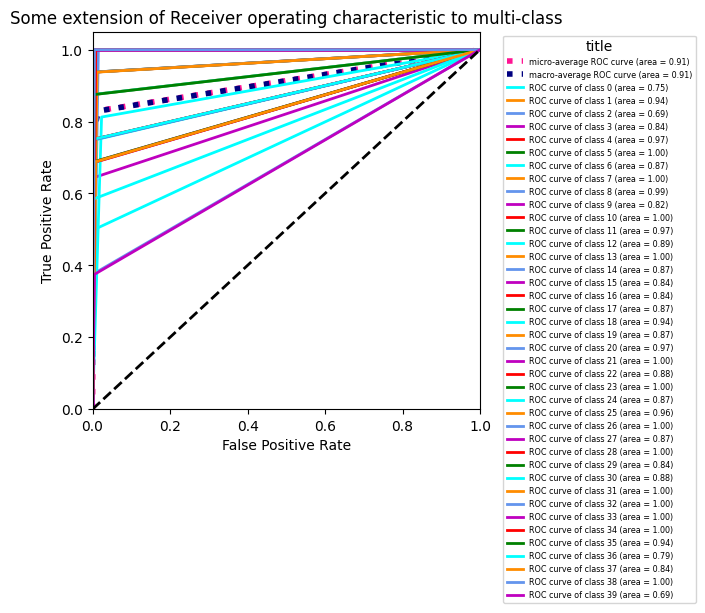

In [ ]:
from sklearn.preprocessing import label_binarize
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

class_array = []
i = 0
while i < n_classes:
  class_array.append(i)
  i += 1
i = 0
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(label_binarize(y_test,class_array )[:, i], label_binarize(pred_RF,class_array)[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(label_binarize(y_test,class_array ).ravel(), label_binarize(pred_RF,class_array).ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure(figsize=(5, 5), dpi=100)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'm', 'r','green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right", )

from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('xx-small')

plt.legend( title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)

plt.show()



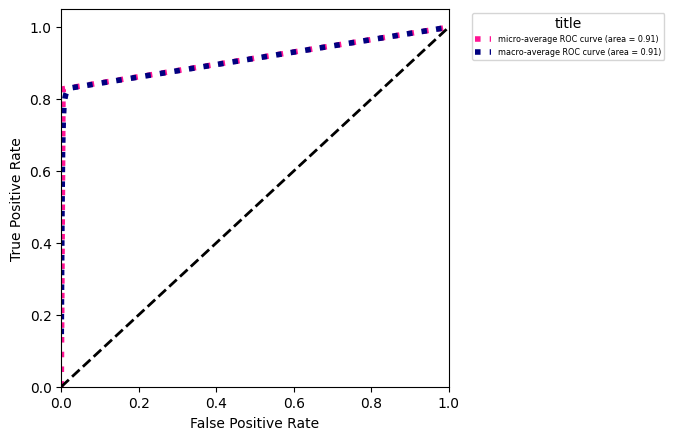

In [ ]:
# Plot macro-micro ROC curves
plt.figure(figsize=(5, 5), dpi=100)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", )

from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('xx-small')

plt.legend( title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)

plt.show()


In [ ]:
def getPred(model, img):
  featureVector = cnnModel.predict(x_test[arn].reshape(1,224,224,3))
  
  return model.predict(pca.transform(featureVector.reshape(featureVector.shape[0], -1)))

## Seleccionamos un elemento aleatorio de test

import random
arn = random.randint(0, len(x_test))

print ("Prediction for x_test["+str(arn)+"]  from  "+ str(y_test[arn]) )

pred = getPred(clf, x_test[arn]) 
print("Prediction from RF: " + str(pred))

Prediction for x_test[218]  from  30
Prediction from RF: [30]


[20]


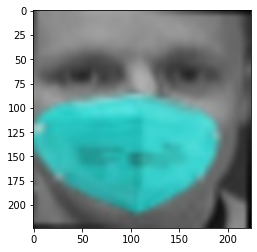

In [ ]:
# Probamos una imagen en concreto
pathToImg = "./drive/MyDrive/TFG/Datasets/ORL_DB_Masked/00021/201.jpg"

def getClfPred(classifier, img_path):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (imgL, imgL))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  kernel = np.ones((5,5),np.float32)/25
  img = cv2.filter2D(img,-1,kernel)
  plt.imshow(img)

  featureVector = cnnModel.predict(img.reshape(1, 224, 224, 3))
  
  return classifier.predict(pca.transform(featureVector.reshape(featureVector.shape[0], -1)))
clfpred = getClfPred(clf, pathToImg)

print(clfpred)